In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import *
from IPython.display import display, HTML, IFrame
%matplotlib inline
from collections import defaultdict
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')


In [2]:
folder = ['compsci-data','jbt-data', 'brands-data-400', 'brands-data-100', 'brands-data-it2', 'jbt-data-it2', 'compsci-data-it2']
MERGE_OTHER = True
ut = 'compsci'
#folder = ['brands-data-it2',  'brands-data-400', 'brands-data-100']
folder = ['{}-data'.format(ut), '{}-data-it2'.format(ut)]

In [3]:


agg_list = []
full_list = []
test_list = []
for f in folder:
    agg =  pd.read_csv('{}/agg.csv'.format(f))
    agg['type'] = f.split('-')[0]
    agg.set_index('id')
    agg_list.append(agg)
   
    full = pd.read_csv('{}/full.csv'.format(f))
    full['type'] = f.split('-')[0]
    full.set_index('id')
    full_list.append( full)
    test = pd.read_csv('{}/test.csv'.format(f))
    test['type'] = f.split('-')[0]
    test.set_index('id')
    test_list.append (test)
aggregated = pd.concat(agg_list)
if MERGE_OTHER:
    aggregated['label'] = aggregated.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)
    full['label'] = full.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)


print(aggregated.describe())
full = pd.concat(full_list)
test_questions = pd.concat(test_list)
aggregated = aggregated[aggregated['_unit_state'] == 'finalized']


def print_info(data):
    avg = pd.merge(data, full, suffixes=['_l', '_r'], on=['id'], how='left')[['id', 'text_readable_r', 'label:confidence', 'label_l', '_golden', 'label_r', '_trust','a','b']].sort_values(['label:confidence', 'label_l' ,'id'])
    renamed_avg = avg.rename(columns={'label_l' : 'assigned_by_crowdflower', 'label_r' : 'proposed_by_annotator'})
    renamed_avg
    return renamed_avg


           _unit_id  _trusted_judgments  label:confidence  label_gold
count  2.469000e+03         2469.000000       2469.000000         0.0
mean   1.563339e+09            3.073714          0.897640         NaN
std    1.926589e+07            0.316089          0.169504         NaN
min    1.534177e+09            2.000000          0.333300         NaN
25%    1.534177e+09            3.000000          0.697400         NaN
50%    1.576061e+09            3.000000          1.000000         NaN
75%    1.576062e+09            3.000000          1.000000         NaN
max    1.576063e+09            6.000000          1.000000         NaN


In [4]:
from sklearn.model_selection import train_test_split

train_i, test_i = train_test_split(aggregated,stratify=aggregated['label'], test_size=0.2)
print('{} {}'.format(len(train_i), len(test_i)))
train_i.to_csv('data.csv')
test_i.to_csv('dev-data.csv')
print(train_i['_golden'].unique())
print(test_i['_golden'].unique())

1972 493
[False]
[False]


### Quality

In [5]:
conf = aggregated[['id','text_html', 'text_readable', 'label:confidence', 'label']]
display(conf[['label:confidence']].describe())
display(conf[['id', 'text_html']].describe())

,label:confidence
count,2465.000000
mean,0.897670
std,0.169431
min,0.333300
25%,0.697400
50%,1.000000
75%,1.000000
max,1.000000


,id,text_html
count,2465,2465
unique,2465,2465
top,D524589606,Windows 7 being the latest stable version of t...
freq,1,1


Sentences with a confidence <= 0.6. Either all three annotators gave a different answer or the annotators are not trustworthy enough.

In [6]:
worst_conf = conf[conf['label:confidence'] <= 0.6]
worst_conf.describe()

,label:confidence
count,83.000000
mean,0.400872
std,0.076972
min,0.333300
25%,0.346250
50%,0.357100
75%,0.478050
max,0.600000


Sentences with 0.60 > confidence < 0.75. Those sentences might introduce noise, but should be useable.

In [7]:
avg_conf = conf[(conf['label:confidence']< 0.75) & (conf['label:confidence']> 0.60)]
avg_conf.describe()

,label:confidence
count,598.000000
mean,0.671247
std,0.022990
min,0.601300
25%,0.657100
50%,0.670600
75%,0.684425
max,0.749800


Sentences with a confidence greater than 0.75

In [8]:
top_conf = conf[conf['label:confidence'] >= 0.80]
top_conf.describe()

,label:confidence
count,1762.000000
mean,0.999522
std,0.008972
min,0.820300
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


All sentences which should contain enough information to train the system (Confidence >= 66%)

In [9]:
useable = conf[conf['label:confidence'] >= 0.67]
useable.describe()

,label:confidence
count,2089.000000
mean,0.951664
std,0.111905
min,0.670000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
def class_summary(df):
    dc = defaultdict(list)
    diff = defaultdict(str)
    for index, row in df.iterrows():
        c = 'text_readable_r' 
        dc[row[c]].append(row['proposed_by_annotator'])
        dc[row[c]] = sorted(dc[row[c]])
        diff[row[c]] = len(set(dc[row[c]]))

    overview = pd.merge( pd.DataFrame(list(dc.items()), columns=[c, 'labels']) , pd.DataFrame(list(diff.items()), columns=[c, 'distinct']), on=c)
    certain = overview[overview['distinct'] > 1]
    return overview, certain
    #return 


class_summary(print_info(conf))[0].groupby('distinct').count()
#len(class_summary(print_info(conf))[1])




,text_readable_r,labels
distinct,,
1,1757,1757
2,643,643
3,65,65


In [11]:
import re
from collections import defaultdict
from pprint import pprint
import operator
d = defaultdict(int)
exp = r'[\w\s+*-]+(?=:\[OBJECT_[AB]\])'
s = set()
for i, row in aggregated.iterrows():
    a = (sorted(re.findall(exp, row['text_html'])))
    d['{} vs. {}'.format(a[0],a[1])] += 1
print(len(d))
pprint(sorted(d.items(), key=operator.itemgetter(1)))

43
[('B+ tree vs. B-tree', 1),
 ('JavaScript vs. Perl', 19),
 ('Floating-point vs. Integer', 20),
 ('Haskell vs. Java', 20),
 ('AWK vs. Perl', 25),
 ('Java vs. Lisp', 25),
 ('MySQL vs. SQLite', 28),
 ('Haskell vs. Python', 31),
 ('Bash vs. Python', 35),
 ('Java vs. Objective-C', 38),
 ('Apple TV vs. iOS', 40),
 ('PHP vs. Ruby', 41),
 ('Oracle vs. PostgreSQL', 45),
 ('AWK vs. Sed', 45),
 ('JavaScript vs. Ruby', 47),
 ('Bluetooth vs. Ethernet', 47),
 ('Lisp vs. Python', 48),
 ('PHP vs. Python', 48),
 ('Perl vs. Ruby', 48),
 ('Windows 98 vs. Windows XP', 49),
 ('Java vs. Perl', 59),
 ('Groovy vs. Java', 60),
 ('CUDA vs. OpenCL', 61),
 ('Windows 8 vs. Windows XP', 61),
 ('Objective-C vs. Swift', 64),
 ('Windows Vista vs. Windows XP', 66),
 ('PHP vs. Perl', 66),
 ('JavaScript vs. Python', 68),
 ('Perl vs. Python', 69),
 ('MySQL vs. PostgreSQL', 75),
 ('Java vs. Ruby', 75),
 ('Java vs. PHP', 77),
 ('Direct3D vs. OpenGL', 80),
 ('JavaScript vs. PHP', 82),
 ('MySQL vs. Oracle', 82),
 ('Java vs

### Hard Sentences

In [12]:
display(print_info(worst_conf.sample(20)).style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn'),subset=['label:confidence']))
merged = print_info(worst_conf)



merged.groupby(by=['text_readable_r']).proposed_by_annotator.describe()

,id,text_readable_r,label:confidence,assigned_by_crowdflower,_golden,proposed_by_annotator,_trust,a,b
26,G1053830693,"I don't know if this sounds right, easier for me to say than to type.. cause I can talk ALOT!!! Just curious if others have done anything similar and if it's do-able, or should I just keep on trying with *AWK* and stay in my mode of frustration when I know that I can do this in §Perl$, but having hands tied here.. a slave to ""da- man"" at work... in the dungeon I stay.... -Zo",0.3392,NONE,False,WORSE,0.9167,Perl,AWK
27,G1053830693,"I don't know if this sounds right, easier for me to say than to type.. cause I can talk ALOT!!! Just curious if others have done anything similar and if it's do-able, or should I just keep on trying with *AWK* and stay in my mode of frustration when I know that I can do this in §Perl$, but having hands tied here.. a slave to ""da- man"" at work... in the dungeon I stay.... -Zo",0.3392,NONE,False,NONE,0.9583,Perl,AWK
28,G1053830693,"I don't know if this sounds right, easier for me to say than to type.. cause I can talk ALOT!!! Just curious if others have done anything similar and if it's do-able, or should I just keep on trying with *AWK* and stay in my mode of frustration when I know that I can do this in §Perl$, but having hands tied here.. a slave to ""da- man"" at work... in the dungeon I stay.... -Zo",0.3392,NONE,False,BETTER,0.95,Perl,AWK
45,L1791483656,*NetBeans* is not §Eclipse$.,0.3406,NONE,False,WORSE,0.7872,Eclipse,NetBeans
46,L1791483656,*NetBeans* is not §Eclipse$.,0.3406,NONE,False,NONE,0.8261,Eclipse,NetBeans
47,L1791483656,*NetBeans* is not §Eclipse$.,0.3406,NONE,False,OTHER,0.8333,Eclipse,NetBeans
17,H1220119094,I'm using a cheapie Microsoft *USB* optical mouse ($20) until somebody makes a decent §Bluetooth$ mouse.,0.3474,WORSE,False,NONE,0.8889,USB,Bluetooth
18,H1220119094,I'm using a cheapie Microsoft *USB* optical mouse ($20) until somebody makes a decent §Bluetooth$ mouse.,0.3474,WORSE,False,WORSE,0.9167,USB,Bluetooth
19,H1220119094,I'm using a cheapie Microsoft *USB* optical mouse ($20) until somebody makes a decent §Bluetooth$ mouse.,0.3474,WORSE,False,BETTER,0.8333,USB,Bluetooth
11,D395506928,But is it better than *Windows 7*? Is it worth upgrading to §Windows 8$?,0.3484,WORSE,False,NONE,0.7941,Windows 7,Windows 8


,count,unique,top,freq
text_readable_r,,,,
"(FWIW, *Smalltalk* (and to a much lesser extent, §Java$)",4,2,BETTER,2
*NetBeans* is not §Eclipse$.,3,3,WORSE,1
"*Python* skills a plus, but not required, especially if you're solid at §JavaScript$.",3,3,WORSE,1
"1.4 GHz or faster required when running *Windows XP*, 2.0 GHz or faster required when running §Windows Vista$ or 7",3,3,WORSE,1
2. We all knew *Windows 8* wouldn't sell better than §Windows 7$.,3,3,WORSE,1
@Slava: FUD! Shameless FUD! *Groovy* is definitely not thousands times slower than §Java$!,4,3,BETTER,2
"According to recent tests, the performance improvements were significant: 26 percent faster for *Windows XP* and 84 percent for §Windows Vista$.",3,3,WORSE,1
"Advantages: decent mac interface build-your-own-screen-layout works without much config hassle with *USB* enttec, DMXKing, etc interfaces (but not enttec §Ethernet$ interfaces ) rock-solid midi input, super-quick configuration there darn good tap-tempo generally simple & intuitive",3,3,WORSE,1
"Any enhancements made to HTML, *JavaScript*, §PHP$, or any other web technology only make Flash better.",4,2,OTHER,2


### Average Sentences

In [13]:
print_info(avg_conf.sample(20)).style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn'),subset=['label:confidence'])

,id,text_readable_r,label:confidence,assigned_by_crowdflower,_golden,proposed_by_annotator,_trust,a,b
35,D507640384,"- Compatibility with *iOS* 6, - Support for iPad mini, - Better support for ""Airplay Mirroring"" TV-Out (through §Apple TV$ 2nd and 3rd generation), - Addition of ""Kid"", ""Numbers"", ""Cyrillic"" and ""Snellen"" optotypes, - Addition of an aspect-ratio calibration step in the geometry calibration panel, - One line improvement in displayable acuity range (e.g.",0.6173,NONE,False,NONE,0.7872,iOS,Apple TV
36,D507640384,"- Compatibility with *iOS* 6, - Support for iPad mini, - Better support for ""Airplay Mirroring"" TV-Out (through §Apple TV$ 2nd and 3rd generation), - Addition of ""Kid"", ""Numbers"", ""Cyrillic"" and ""Snellen"" optotypes, - Addition of an aspect-ratio calibration step in the geometry calibration panel, - One line improvement in displayable acuity range (e.g.",0.6173,NONE,False,NONE,0.8261,iOS,Apple TV
37,D507640384,"- Compatibility with *iOS* 6, - Support for iPad mini, - Better support for ""Airplay Mirroring"" TV-Out (through §Apple TV$ 2nd and 3rd generation), - Addition of ""Kid"", ""Numbers"", ""Cyrillic"" and ""Snellen"" optotypes, - Addition of an aspect-ratio calibration step in the geometry calibration panel, - One line improvement in displayable acuity range (e.g.",0.6173,NONE,False,WORSE,1,iOS,Apple TV
56,M2054169739,"*Python* at least is every bit as good at 'net' programming as §Java$, and faster to develop with.",0.6429,BETTER,False,BETTER,0.8421,Java,Python
57,M2054169739,"*Python* at least is every bit as good at 'net' programming as §Java$, and faster to develop with.",0.6429,BETTER,False,BETTER,0.9583,Java,Python
58,M2054169739,"*Python* at least is every bit as good at 'net' programming as §Java$, and faster to develop with.",0.6429,BETTER,False,NONE,1,Java,Python
47,S2996250652,"VBA), C#, *Java*, Web(HTML,DHTML, XML), SQL Mediocre: §PHP$ Beginner:PERL, CGI, Cold Fusion,Oracle, Ruby",0.6456,NONE,False,NONE,0.9167,Java,PHP
48,S2996250652,"VBA), C#, *Java*, Web(HTML,DHTML, XML), SQL Mediocre: §PHP$ Beginner:PERL, CGI, Cold Fusion,Oracle, Ruby",0.6456,NONE,False,BETTER,1,Java,PHP
49,S2996250652,"VBA), C#, *Java*, Web(HTML,DHTML, XML), SQL Mediocre: §PHP$ Beginner:PERL, CGI, Cold Fusion,Oracle, Ruby",0.6456,NONE,False,NONE,0.9048,Java,PHP
19,K1613108628,"learn some perl, java and *Python*, §Lisp$ if you want to look old school and start hacking around linux and bsd, make sure you have a decent understanding of windows admin crap because it'll always play in, buy yourself a cheap cisco or addtran and start teaching yourself the nitty gritty of networking",0.6522,NONE,False,NONE,0.875,Python,Lisp


### Easy Sentences

In [14]:
#print_info(top_conf.sample(20)).style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn_r'),subset=['label:confidence'])

### All Sentences

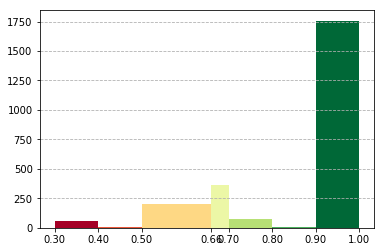

In [15]:
color_map = plt.cm.get_cmap('RdYlGn')
#plt.title('Confidence of Labeling')
plt.grid(axis='y', linestyle='dashed')
ticks = [0.3, 0.4, 0.5, 0.66, 0.7, 0.8, 0.9, 1]
plt.xticks(ticks)
n, bins, patches = plt.hist(
    aggregated['label:confidence'], bins=ticks, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))
plt.show()

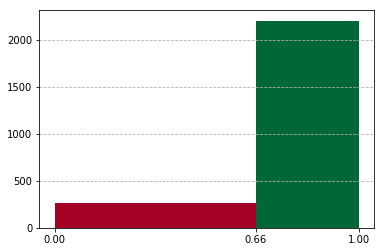

In [16]:
color_map = plt.cm.get_cmap('RdYlGn')
#plt.title('Confidence of Labeling')
plt.grid(axis='y', linestyle='dashed')
ticks = [0.0,  0.66, 1]
plt.xticks(ticks)
n, bins, patches = plt.hist(
    aggregated['label:confidence'], bins=ticks, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))
plt.show()

## Results

**Label Distribution**

In [17]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def show_dist(labels):

    plt.figure(figsize=plt.figaspect(1))
    plt.pie(
        labels.value_counts().values,
        labels=labels.value_counts().keys().tolist(),
        radius=2,
        autopct=make_autopct(labels.value_counts().values))
    plt.show()


**All sentences**

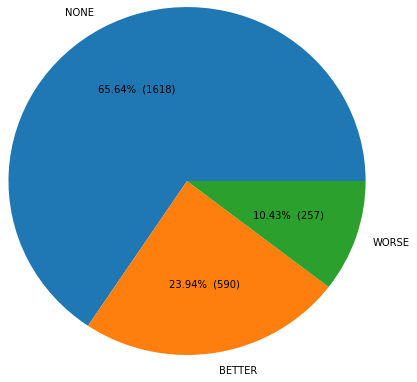

In [18]:
show_dist(aggregated['label'])